# <a id='toc1_'></a>[Analysis of the 2023/24 La Liga Clubs](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Analysis of the 2023/24 La Liga Clubs](#toc1_)    
  - [1. Introduction](#toc1_1_)    
    - [1.1. Importing Essential Packages](#toc1_1_1_)    
    - [1.2 Loading Dataset](#toc1_1_2_)    
  - [2. Data](#toc1_2_)    
    - [2.1. Clubs](#toc1_2_1_)    
    - [2.2. Players](#toc1_2_2_)    
    - [2.3. Transfer Market](#toc1_2_3_)    
  - [3. EDA: Exploratory Data Analysis](#toc1_3_)    
  - [4. Market Analysis](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[1. Introduction](#toc0_)

Football data from Transfermarkt is highly valuable because it provides comprehensive insights into player transfers, performance statistics, and market values, which are essential for clubs, analysts, and fans. Aggregation detailed data on player contracts, injuries, and historical transfers, making it a vital tool for scouting, negotiating transfers, and understanding the dynamics of the football market. For analysts and researchers, this data allows for in-depth analysis of player development, team strategies, and financial trends within the sport. Additionally, the transparency and breadth of information on Transfermarkt enhance decision-making for clubs and enrich the fan experience by offering a deeper understanding of the game.

By analyzing these datasets, we can address several business questions, such as:

1. What are the technical attributes of each player?
2. What insights can we gain from each game to enhance a club's efficiency?
3. Who is the most valuable player, both technically and financially?
4. Which club has been the most successful in the transfer market?
5. What factors influence a player's market value?
6. Do expensive transfers lead to improved performance?
7. Which agent has been the most successful in the transfer market?
8. What is the correlation between a player's physical aspects and their market performance?
9. Which positions yield the highest return on investment in the transfer market?
10. How does a player's performance in international tournaments affect their market value?
11. What trends can be identified in player transfers over the past few seasons?
12. How do club investments in youth development compare to their market success?
13. What role does a player's nationality play in their market value?

We aim to answer some of these questions throughout this report.

### <a id='toc1_1_1_'></a>[1.1. Importing Essential Packages](#toc0_)

In [4]:
import pandas as pd
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [5]:
pd.set_option('display.max_columns', None)

### <a id='toc1_1_2_'></a>[1.2 Loading Dataset](#toc0_)

The dataset, from Transfermarkt, comprises multiple CSV files with information on competitions, games, clubs, players, and appearances. (source: [kaggle](https://www.kaggle.com/datasets/davidcariboo/player-scores))

In [6]:
appearances = pd.read_csv("appearances.csv")
club_games = pd.read_csv("club_games.csv")
clubs = pd.read_csv("clubs.csv")
competitions = pd.read_csv("competitions.csv")
game_events = pd.read_csv("game_events.csv")
game_lineups = pd.read_csv("game_lineups.csv")
games = pd.read_csv("games.csv")
player_valuations = pd.read_csv("player_valuations.csv")
players = pd.read_csv("players.csv")
transfers = pd.read_csv("transfers.csv")

## <a id='toc1_2_'></a>[2. Data](#toc0_)

Given the size and complexity of the dataset, we first extracted the desired dataframes from it, focusing on three key areas: clubs, players, and market.

### <a id='toc1_2_1_'></a>[2.1. Clubs](#toc0_)

We began by selecting all the clubs competing in the 2023-2024 La Liga season.

In [7]:
# finding the competion ID of Spain League
competitions["competition_id"][competitions["competition_code"] =="laliga"]

9    ES1
Name: competition_id, dtype: object

In [8]:
# building a dataframe contains all laliga clubs in 2023/24 season
clubs_spain = clubs[((clubs["domestic_competition_id"]== "ES1") & (clubs["last_season"]== 2024))]

In [9]:
print(clubs_spain.shape)
clubs_spain.head(2)

(20, 17)


,club_id,club_code,name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,last_season,filename,url
61,1108,deportivo-alaves,Deportivo Alavés S.A.D.,ES1,NaN,25,26.0,12,48.0,4,Mendizorroza,19840,+€4.20m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/deportivo-alav...
65,13,atletico-madrid,Club Atlético de Madrid S.A.D.,ES1,NaN,26,27.6,16,61.5,17,Civitas Metropolitano,70460,€-91.10m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/atletico-madri...


In [10]:
clubs_spain.isna().sum()[clubs_spain.isna().sum() > 0]

total_market_value    20
coach_name            20
dtype: int64

Since the dataset lacks information on "total market value" and "coach name," we decided to drop these columns. Additionally, we removed the "filename" and "URL" columns, as they are not needed.

In [11]:
clubs_spain.drop(["total_market_value", "coach_name", "filename", "url"], axis = 1, inplace= True)

### <a id='toc1_2_2_'></a>[2.2. Players](#toc0_)

Next, we built a dataset of players active during the 2023/24 La Liga season by following these steps:

1. Select players who plays in La Liga from the appearance dataset.
2. Limit the time frame to the 2023/24 season.
3. Construct the dataset by merging player appearances with player information (from the players dataset) and game details (from the game lineup dataset).

In [12]:
# choosing games of our desierd clubs
related_clubs_ids = clubs_spain["club_id"]
related_appearances = appearances[appearances["player_club_id"].isin(related_clubs_ids)]

In [13]:
related_appearances['date'] = pd.to_datetime(related_appearances['date'], errors='coerce')

# Filter for months from August 2023 to June 2024 and create season 
appearances23_24 = related_appearances[
    ((related_appearances['date'].dt.year == 2023) & (related_appearances['date'].dt.month >= 8)) |
    ((related_appearances['date'].dt.year == 2024) & (related_appearances['date'].dt.month <= 6))]

appearances23_24['season'] = 2023

In [14]:
# mergeing
players_info = appearances23_24.merge(
    competitions[['competition_id', 'name', 'sub_type', 'type', 'country_id', 'country_name']],      
    on = 'competition_id', how = 'left' )
players_info.rename(columns={"name": "competition_name", "type": "type_of_competition", "date": "date_of_game"}, inplace = True)

players_info = players_info.merge(
    players[["player_id",'first_name', 'last_name','last_season','country_of_birth','date_of_birth', 'sub_position', 'position',
       'foot', 'height_in_cm', "country_of_citizenship", 'contract_expiration_date', 'agent_name', "market_value_in_eur",
       'highest_market_value_in_eur']],
    on = 'player_id', how = "left")

players_info = players_info.merge(
    game_lineups[["game_id","player_id", "type", "team_captain"]],
    on = ['game_id', "player_id"], how = "left")
players_info.rename(columns={"position": "position_in_game"}, inplace = True)

In [15]:
players_info['date_of_birth'] = pd.to_datetime(players_info['date_of_birth'], errors='coerce')

players_info['age'] = players_info.apply(
    lambda row: row['date_of_game'].year - row['date_of_birth'].year -
      ((row['date_of_game'].month, row['date_of_game'].day) < (row['date_of_birth'].month, row['date_of_birth'].day)),
    axis=1)

**Missing Values**

In [16]:
players_info.isna().sum()[players_info.isna().sum() > 0]

country_name                    982
first_name                      877
country_of_birth                122
foot                             72
height_in_cm                     45
contract_expiration_date        448
agent_name                     3025
market_value_in_eur              21
highest_market_value_in_eur      21
type                           9454
team_captain                   9454
dtype: int64

The dataset contains several missing values that need to be addressed. For the "country_name" column, we can fill the missing values with "Europa," as these gaps correspond to matches from one of the Europa tournaments.

In [17]:
players_info["country_name"].fillna("Europa", inplace=True)

We can fill the missing values in the "first_name" column with "not defined," but first, we need to ensure that there are no players with the same name in our dataset.

In [18]:
# Filter rows where 'first_name' is NaN
nan_first_name_rows = players_info[players_info["first_name"].isna()]

# Find duplicates in 'player_name' where 'player_club_id' is different
duplicates_different_club = nan_first_name_rows[nan_first_name_rows.duplicated(subset=["player_name"], keep=False)]

# Further filter to find cases where 'player_club_id' is different
duplicates_different_club = duplicates_different_club.groupby("player_name").filter(lambda x: x["player_club_id"].nunique() > 1)

duplicates_different_club["player_name"].value_counts()

Portu               41
Gabriel Paulista    24
Name: player_name, dtype: int64

In [19]:
players_info[players_info["player_name"]=="Gabriel Paulista"]["player_id"]

18       149498
310      149498
732      149498
1852     149498
2165     149498
2402     149498
2881     149498
3106     149498
3684     149498
3871     149498
4183     149498
4548     149498
4953     149498
5609     149498
5905     149498
6624     149498
6784     149498
6945     149498
7478     149498
8159     149498
8590     149498
9039     149498
9266     149498
11877    149498
Name: player_id, dtype: int64

In [20]:
players_info[players_info["player_name"]=="Portu"]["player_id"]

199      99353
498      99353
825      99353
1016     99353
1349     99353
1568     99353
1851     99353
2114     99353
2817     99353
3012     99353
3406     99353
3605     99353
3948     99353
4358     99353
4576     99353
4920     99353
5131     99353
5576     99353
5763     99353
5999     99353
6186     99353
6845     99353
7067     99353
7253     99353
7532     99353
7703     99353
8075     99353
8523     99353
8806     99353
9091     99353
9247     99353
9545     99353
10007    99353
10198    99353
10539    99353
10854    99353
11088    99353
11309    99353
11571    99353
12045    99353
12092    99353
Name: player_id, dtype: int64

We have no players with the same names.

In [21]:
players_info["first_name"].fillna("not defined", inplace=True)

For the missing values in "country_of_birth," we can use the available citizenship information to fill them in, although this may not be entirely accurate.

In [22]:
# Filter rows where 'country_of_birth' is NaN and get the player names
nan_country_players = players_info[players_info["country_of_birth"].isna()]["player_name"].unique()

# Filter the dataset for these player names
filtered_players = players_info[players_info["player_name"].isin(nan_country_players)]

# Group by 'player_name' and apply the list of 'country_of_citizenship'
citizenship_by_player = filtered_players.groupby("player_name")["country_of_citizenship"].apply(list)

# Update 'country_of_birth' where it is NaN with 'country_of_citizenship'
players_info.loc[players_info["player_name"].isin(nan_country_players), "country_of_birth"] = \
    players_info.loc[players_info["player_name"].isin(nan_country_players), "country_of_birth"].fillna(
        players_info["country_of_citizenship"])


We also have missing values in the "foot" column. To address this, we can determine the predominant foot used by players in their respective positions and use that information to fill in the missing values.

In [23]:
# Filter rows where 'foot' is NaN and get the player names
nan_country_players = players_info[players_info["foot"].isna()]["player_name"].unique()

# Get the first sub-position for each player with missing 'foot'
first_positions = players_info[players_info["player_name"].isin(nan_country_players)].groupby("player_name")["sub_position"].first()

# Extract unique sub-positions
unique_positions = first_positions.unique()

# Get the distribution of 'foot' values for each unique sub-position
position_foot_distribution = players_info[players_info["sub_position"].isin(unique_positions)]
distribution = position_foot_distribution.groupby('sub_position')['foot'].value_counts().unstack(fill_value=0)

# Create a mapping of 'sub_position' to the most common 'foot' value
foot_fill_map = distribution.idxmax(axis=1).to_dict()

# Fill NaN values in 'foot' based on the 'sub_position'
players_info['foot'] = players_info.apply(
    lambda row: foot_fill_map.get(row['sub_position'], row['foot']) if pd.isna(row['foot']) else row['foot'],
    axis=1
)


The majority of the missing values in the "height" column are associated with four players, which we can fill in manually. For the remaining missing values, we will first compare the median and mean heights. Since there is no significant difference between the two, we can fill the NaN values with either the median or the mean.

In [24]:
players_info[players_info["height_in_cm"].isna()]["player_name"].value_counts()

Hugo González         10
Carlos Romero          8
Damián Rodríguez       5
Alberto Risco          4
Javi Rodríguez         2
Pau Mascaró            2
Tomás Mendes           2
Rubén Quintanilla      1
Pau Ferrer             1
Gorka Rivera           1
Ali Fadal              1
Enric García           1
Marcos Fernández       1
Aboubacar Bassinga     1
Yadam Santana          1
Gabriel Palmero        1
Jeremy Jorge           1
Yoel Lago              1
Eneko Ortiz            1
Name: player_name, dtype: int64

In [25]:
# Update 'height' for 'Hugo González', "Carlos Romero", "Damián Rodríguez" and "Alberto Risco"
players_info.loc[players_info["player_name"] == "Hugo González", ["height_in_cm"]] = ["192"]
players_info.loc[players_info["player_name"] == "Carlos Romero", ["height_in_cm"]] = ["174"]
players_info.loc[players_info["player_name"] == "Damián Rodríguez", ["height_in_cm"]] = ["180"]
players_info.loc[players_info["player_name"] == "Alberto Risco", ["height_in_cm"]] = ["157"]

In [26]:
players_info["height_in_cm"] = pd.to_numeric(players_info["height_in_cm"], errors='coerce')

# Calculate the mean
mean_height = players_info["height_in_cm"].mean()
median_height = players_info["height_in_cm"].median()

print("mean hight is:  ", mean_height)
print("median of height is:  ", median_height)

# Fill the rest of NaN values with the calculated mean
players_info["height_in_cm"].fillna(mean_height, inplace=True)


mean hight is:   181.5550153945876
median of height is:   182.0


To fill the NaN values in the "team_captain" column, I followed these steps:

1. Identified the game IDs for the matches with missing values in "team_captain."
2. Checked the player_info dataset to see if there was any information about the team captain for those matches (there wasn't).
3. Examined the game_lineups dataset to find relevant data for these games (again, there was none).
4. Finally, I looked at the club captain for other matches and determined if he participated in the specific game. If he did, I used his name as the captain for that match.

In [27]:
players_info[players_info["team_captain"].isna()]["player_name"].value_counts()

Raúl García          48
Federico Valverde    42
Antonio Rüdiger      40
Jan Oblak            39
Rodrygo              39
                     ..
Quique Fernández      1
Diego Collado         1
Rubén Quintanilla     1
Iker Almena           1
Eneko Ortiz           1
Name: player_name, Length: 522, dtype: int64

In [28]:
# Create a function to fill NaN values
def fill_nan_team_captain(df):
    # Iterate over unique game_ids where 'team_captain' is NaN
    for game_id in df.loc[df['team_captain'].isna(), 'game_id'].unique():
        # Check if there is any row with team_captain == 1 for this game_id
        if (df.loc[(df['game_id'] == game_id) & (df['team_captain'] == 1)].shape[0] > 0):
            # If so, fill NaN values with 0 for this game_id
            df.loc[(df['game_id'] == game_id) & (df['team_captain'].isna()), 'team_captain'] = 0

# Apply the function to the players_info DataFrame
fill_nan_team_captain(players_info)

In [29]:
# Filter the rows where 'team_captain' is NaN and get the corresponding 'game_id'
game_ids_with_nan_team_captain = players_info[players_info['team_captain'].isna()]['game_id']
# the unique game_id values where team_captain is NaN
unique_game_ids_with_nan_team_captain = game_ids_with_nan_team_captain.unique()

# Check which of these game_id values are present in game_lineups['game_id']
matching_game_ids = game_lineups[game_lineups['game_id'].isin(unique_game_ids_with_nan_team_captain)]['game_id'].unique()

# Display the matching game_ids
print("Matching game IDs found in game_lineups:", matching_game_ids)


Matching game IDs found in game_lineups: []


In [30]:
# Filter the DataFrame to include only rows where 'team_captain' is '1'
captain_ones = players_info[players_info['team_captain'] == 1]

# Group by 'player_club_id' and 'player_id', then count occurrences of '1'
counts = captain_ones.groupby(['player_club_id', 'player_id']).size().reset_index(name='count')

# For each 'player_club_id', find the player_id with the maximum count
max_counts = counts.loc[counts.groupby('player_club_id')['count'].idxmax()]
max_counts


,player_club_id,player_id,count
0,13,74229,12
2,131,74857,7
6,150,203496,7
9,237,278296,10
11,331,298589,7
13,367,517753,9
14,368,15956,9
16,418,58884,9
18,472,566574,9
19,621,96718,7


In [31]:
nan_mask = players_info['team_captain'].isna()

# Create a mapping for player_club_id to the player_id with the maximum count
max_captains = max_counts.set_index('player_club_id')['player_id'].to_dict()

# Update 'team_captain' in players_info
def fill_team_captain(row):
    if pd.isna(row['team_captain']):
        club_id = row['player_club_id']
        if club_id in max_captains and row['player_id'] == max_captains[club_id]:
            return 1
        else:
            return 0
    return row['team_captain']

players_info['team_captain'] = players_info.apply(fill_team_captain, axis=1)

We can fill missing values in the position_in_game column by using the sub_position data from the players DataFrame.

In [32]:
players_info["position_in_game"].value_counts()

Defender      4158
Midfield      3714
Attack        3686
Goalkeeper     802
Name: position_in_game, dtype: int64

In [33]:
nan_rows = players_info[players_info['position_in_game'].isna()]

# Retrieve 'sub_position' for player_ids with missing 'position_in_game'
sub_positions = players.set_index('player_id')['sub_position']

# Map 'sub_position' to 'position_in_game' where it's missing
players_info['position_in_game'] = players_info['position_in_game'].fillna(
    players_info['player_id'].map(sub_positions))

For missing information in "type" we use this estimation:

If a player has played 90 or more minutes, set the type to 'starting_lineup'.
If he has played less than 90 minutes, set the type to 'substitutes'.

In [34]:
players_info["type"].value_counts()

starting_lineup    2046
substitutes         860
Name: type, dtype: int64

In [35]:
players_info['type'] = players_info.apply(
    lambda row: 'starting_lineup' if pd.isna(row['type']) and row['minutes_played'] >= 90 else 
    ('substitutes' if pd.isna(row['type']) else row['type']), axis=1)

### <a id='toc1_2_3_'></a>[2.3. Transfer Market](#toc0_)

In this section, we begin by constructing our desired dataset for the transfer market, starting from January 1, 2023. This dataset will include information on players and their performances, focusing on those who joined or left La Liga.

In [36]:
transfers['transfer_date'] = pd.to_datetime(transfers['transfer_date'])

# Filter the dataset based on the conditions
start_date = pd.Timestamp('2023-01-01')

# Filter the dataset based on the conditions
laliga_transfer = transfers[
    (transfers['transfer_date'] >= start_date) & 
    ((transfers['from_club_id'].isin(clubs_spain['club_id'])) | (transfers['to_club_id'].isin(clubs_spain['club_id'])))]


We can establish a measure to calculate palyers productivity:
$$
Productivity = \frac{(w_{goal} \times Goals) + (w_{assist} \times Assists)}{Minutes  Played} \times 90
$$

In [37]:
non_goalkeepers = players_info[players_info['position_in_game'] != 'Goalkeeper']

In [38]:
# Define weights
w_goal = 2
w_assist = 1

# Calculate Weighted Productivity
non_goalkeepers['productivity'] = ((w_goal * players_info['goals'] + w_assist * players_info['assists']) / players_info['minutes_played']) * 90

In [39]:
laliga_transfer = laliga_transfer.merge(
    players[["player_id",'first_name', 'last_name','last_season','current_club_id','country_of_birth','country_of_citizenship',
            'date_of_birth', 'sub_position', 'position','foot', 'height_in_cm', "country_of_citizenship", 'contract_expiration_date',
            'agent_name', 'current_club_name','highest_market_value_in_eur']],
    on = 'player_id', how = "left")

laliga_transfer = laliga_transfer.merge(
    non_goalkeepers[["player_id",'productivity']],
    on = 'player_id', how = "left")

In [40]:
laliga_transfer['date_of_birth'] = pd.to_datetime(laliga_transfer['date_of_birth'], errors='coerce')
laliga_transfer['transfer_date'] = pd.to_datetime(laliga_transfer['transfer_date'], errors='coerce')

laliga_transfer['age'] = laliga_transfer.apply(
    lambda row: row['transfer_date'].year - row['date_of_birth'].year,  axis=1)

## <a id='toc1_3_'></a>[3. EDA: Exploratory Data Analysis](#toc0_)

We conducted a preliminary data analysis to extract basic information, which revealed the following:

- Real Madrid (77%), Atlético Madrid (61%), and Sevilla (56%) have the highest percentages of foreign players, while Osasuna and Athletic Bilbao have the fewest, with less than 10%.
- There is a 5.6 year difference between the oldest and youngest teams. Rayo Vallecano, with an average player age of 29, is the oldest team, while Barcelona, with an average age of 23.4, is the youngest.
- Among non-goalkeeper players, while Federico Valverde (from Real Madrid) has the most playing time, Bebe is the most productive player.

Note: Goalkeepers are excluded from the evaluation of player performance. Additionally, the performance of defenders and defensive midfielders has not been thoroughly assessed due to a lack of information on accurate passing and successful defensive actions.

In [41]:
sort_by_foreigners = clubs_spain.sort_values('foreigners_percentage',ascending=False)[::-1]

fig = px.bar(sort_by_foreigners, y='club_code', x='foreigners_percentage')

fig.update_layout(height=700,title="Foreigners Percentage in Laliga's club")

fig.update_yaxes(title_text='club', showgrid=False)

fig.update_xaxes(title_text='Foreigners Percentage', showgrid=False)

fig.show()

In [42]:
sort_by_age = clubs_spain.sort_values('average_age',ascending=False)[::-1]

fig = px.bar(sort_by_age, y='club_code', x='average_age')
fig.update_layout(height=700,title="Average age of players in each of Laliga's clubs")

fig.update_yaxes(title_text='club',showgrid=False)

fig.update_xaxes(title_text='Average Age', showgrid=False)

fig.show()

In [43]:
# Calculate top players based on minutes played
most_minutes = (non_goalkeepers.groupby('player_name')['minutes_played']
                .sum()
                .sort_values(ascending=False)
                .reset_index()
                .head(15))

# Calculate top scorers
top_scorers = (non_goalkeepers.groupby('player_name')['goals']
               .sum()
               .sort_values(ascending=False)
               .reset_index()
               .head(10))

# Calculate top assist makers
top_assistmen = (non_goalkeepers.groupby('player_name')['assists']
                 .sum()
                 .sort_values(ascending=False)
                 .reset_index()
                 .head(10))

# Calculate top productive players
most_productive = (non_goalkeepers.groupby('player_name')['productivity']
                   .sum()
                   .sort_values(ascending=False)
                   .reset_index()
                   .head(10))

In [44]:
def create_bar_plot(data, x_col, y_col, color_col, title, x_title, y_title, color_scale="blues"):
    """
    Parameters:
    - data: DataFrame containing the data to plot.
    - x_col: Name of the column to use for the x-axis.
    - y_col: Name of the column to use for the y-axis.
    - color_col: Name of the column to use for the color.
    - title: Title of the plot.
    - x_title: Label for the x-axis.
    - y_title: Label for the y-axis.
    - color_scale: Color scale for the bar colors.
    """
    fig = px.bar(data, x=x_col, y=y_col, color=color_col, color_continuous_scale=color_scale)
    fig.update_layout(title=title)
    fig.update_xaxes(title_text=x_title)
    fig.update_yaxes(title_text=y_title)
    fig.show()

# Plot for most minutes played
create_bar_plot(
    most_minutes,
    x_col='player_name',
    y_col='minutes_played',
    color_col='minutes_played',
    title='Players with Most Minutes Played',
    x_title='Players',
    y_title='Minutes Played'
)

# Plot for most productive players
create_bar_plot(
    most_productive,
    x_col='player_name',
    y_col='productivity',
    color_col='productivity',
    title='Most Productive Players',
    x_title='Players',
    y_title='Productivity (Goals + Assists)'
)

# Plot for top scorers
create_bar_plot(
    top_scorers,
    x_col='player_name',
    y_col='goals',
    color_col='goals',
    title='Top Scorers',
    x_title='Players',
    y_title='Goals'
)


Which player positions score the most goals?

In [45]:
goals_by_position = (players_info.groupby('sub_position')['goals'].sum().sort_values(ascending=False).reset_index())


# Create a bar chart using Plotly
fig = px.bar(goals_by_position, 
             x='sub_position', 
             y='goals', 
             title='Total Goals by Position',
             labels={'sub_position': 'Sub-Position', 'goals': 'Total Goals'},
             text_auto=True)

fig.update_layout(xaxis_title="Sub-Position", 
                  yaxis_title="Total Goals", 
                  xaxis_tickangle=-45)

fig.show()

## <a id='toc1_4_'></a>[4. Market Analysis](#toc0_)

In [46]:
laliga_market = laliga_transfer.copy()

Atlético Madrid had the highest expenditure and generated the most revenue in the transfer market, while Valencia recorded the highest net market value overall.

In [63]:
# Prepare data for the first plot (from_club_name)
market_value_sum = laliga_market.groupby('from_club_name')['market_value_in_eur'].sum().reset_index() 
market_value_sum = market_value_sum.sort_values(by='market_value_in_eur', ascending=False).head(10)

# Prepare data for the second plot (to_club_name)
market_value_sum_to = laliga_market.groupby('to_club_name')['market_value_in_eur'].sum().reset_index()
market_value_sum_to = market_value_sum_to.sort_values(by='market_value_in_eur', ascending=False).head(10)

# Create subplots
fig = make_subplots(rows=1, cols=2, 
                    subplot_titles=('Top 10 (from) Clubs by Total Market Value', 'Top 10 (to) Clubs by Total Market Value'))

# first bar chart
fig.add_trace(go.Bar(
    x=market_value_sum['from_club_name'],
    y=market_value_sum['market_value_in_eur'],
    name='From Clubs'
), row=1, col=1)

# second bar chart
fig.add_trace(go.Bar(
    x=market_value_sum_to['to_club_name'],
    y=market_value_sum_to['market_value_in_eur'],
    name='To Clubs'
), row=1, col=2)

fig.update_layout(
    title_text='Top 10 Clubs by Total Market Value (From and To)',
    xaxis_title='Club',
    yaxis_title='Market Value (in EUR)',
)

fig.show()


In [62]:
fig = px.bar(clubs_spain, 
             x='name', 
             y='net_transfer_record', 
             title='Clubs by Net Transfer',
             labels={'name': 'Club', 'net_transfer_record': 'Net Transfer (in EUR)'})

fig.show()

**high value players in laliga**


From the figure below, we can see that Kylian Mbappe from Real Madrid is the most valuable player, followed by Julian Alvarez from Atlético Madrid, with Dani Olmo from Barcelona in third place. Overall, Real Madrid stands out as the most valuable club.

In [61]:
high_val_club = laliga_market.loc[laliga_market.groupby('current_club_name')['market_value_in_eur'].idxmax()].nlargest(20, 'market_value_in_eur')
high_val_player_names = high_val_club['player_name'].tolist()

fig = go.Figure()

fig.add_trace(go.Bar(
    x=high_val_club['current_club_name'],
    y=high_val_club['market_value_in_eur'],
    text=[f"{player}, {age}" for player, age in zip(high_val_club['player_name'], high_val_club['age'])],
    textposition='outside' 
))

fig.update_layout(
    title='Players with Highest Market Value by Club',
    xaxis_title='Club Name',
    yaxis_title='Current Market Value (EUR)',
    xaxis_tickangle=-45,
    height=600, 
    width=1000,
)

fig.show()


In [50]:
# Filter the laliga_market dataset
high_value_players = laliga_market[laliga_market['player_name'].isin(high_val_player_names)]

**Comparison between the Highest Market Value Player and Other Players**

This comparison considers age, height, position, and foot characteristics:

- Players with the highest market values are generally between 20-23 years old or 26-27 years old, while the majority of other players fall between 24 and 25 years old.
- The largest percentage of players in both groups have a height ranging from 178 to 182 cm.
- The attacking position dominates in both groups, with the highest number of players and the most expensive ones as well.
- Most players in both groups are right-footed, with less than 10% able to play proficiently with both feet.
- The most minutes played by a high value player was 3,601, whereas the most minutes played by a regular player reached 5,000.

In [51]:
# Grouping by 'player_id' and aggregating
transfer_player_info = players_info.groupby('player_id').agg({
    'player_club_id': 'first',  
    'player_current_club_id': 'first',
    'player_name': 'first',
    'yellow_cards': 'sum',
    'red_cards': 'sum',
    'goals': 'sum',
    'assists': 'sum',
    'minutes_played': 'sum',
    'season': 'first',
    'country_id': 'first',
    'country_name': 'first',
    'first_name': 'first',
    'last_name': 'first',
    'last_season': 'first',
    'country_of_birth': 'first',
    'date_of_birth': 'first',
    'sub_position': 'first',
    'position_in_game': 'first',
    'foot': 'first',
    'height_in_cm': 'first',
    'country_of_citizenship': 'first',
    'type': 'first',
    'team_captain': 'first',
    'age': 'first',
    'contract_expiration_date': 'first',
    'agent_name': 'first',
    "market_value_in_eur": 'first',
    'highest_market_value_in_eur': 'first'
}).reset_index()

In [52]:
# Add a column to indicate the group for both datasets
transfer_player_info['group'] = 'All Players'
high_value_players['group'] = 'High Value Players'

combined_data = pd.concat([transfer_player_info[['age', 'group']],
                           high_value_players[['age', 'group']]])

# Age Distribution Comparison
fig_age = px.histogram(combined_data, x='age', color='group', 
                        title='Age Distribution: High Value Players vs All Players',
                        barmode='overlay', 
                        histnorm='percent', 
                        color_discrete_map={'All Players': 'blue', 'High Value Players': 'navy'},
                        nbins=20)
fig_age.update_layout(xaxis_title='Age', yaxis_title='Percentage of Players')
fig_age.show()

# Height Distribution Comparison 
combined_height_data = pd.concat([transfer_player_info[['height_in_cm', 'group']],
                                   high_value_players[['height_in_cm', 'group']]])

fig_height = px.histogram(combined_height_data, x='height_in_cm', color='group', 
                           title='Height Distribution: High Value Players vs All Players',
                           barmode='overlay',
                           histnorm='percent', 
                           color_discrete_map={'All Players': 'blue', 'High Value Players': 'navy'},
                           nbins=20)
fig_height.update_layout(xaxis_title='Height (cm)', yaxis_title='Percentage of Players')
fig_height.show()

# Position Distribution Comparison 
combined_position_data = pd.concat([transfer_player_info[['position_in_game', 'group']],
                                     high_value_players[['position', 'group']].rename(columns={'position': 'position_in_game'})])

fig_position = px.histogram(combined_position_data, x='position_in_game', color='group', 
                             title='Position Distribution: High Value Players vs All Players',
                             barmode='overlay',
                             histnorm='percent', 
                             color_discrete_map={'All Players': 'blue', 'High Value Players': 'navy'})
fig_position.update_layout(xaxis_title='Position Played', yaxis_title='Percentage of Players')
fig_position.show()

# Footedness Distribution Comparison 
combined_foot_data = pd.concat([transfer_player_info[['foot', 'group']],
                                 high_value_players[['foot', 'group']]])

fig_foot = px.histogram(combined_foot_data, x='foot', color='group', 
                         title='Footedness Distribution: High Value Players vs All Players',
                         barmode='overlay',
                         histnorm='percent', 
                         color_discrete_map={'All Players': 'blue', 'High Value Players': 'navy'})
fig_foot.update_layout(xaxis_title='Dominant Foot', yaxis_title='Percentage of Players')
fig_foot.show()


In [60]:
# Filter 
high_value_players_minutes = transfer_player_info[transfer_player_info['player_name'].isin(high_val_player_names)]

# Create traces for the two groups
trace_all_players = go.Scatter(
    x=transfer_player_info.index,  # X-axis could be index or a relevant player identifier
    y=transfer_player_info['minutes_played'],
    mode='lines',
    name='All Players',
    line=dict(color='blue')
)

trace_high_value_players = go.Scatter(
    x=high_value_players_minutes.index,  # X-axis could be index or a relevant player identifier
    y=high_value_players_minutes['minutes_played'],
    mode='lines',
    name='High Value Players',
    line=dict(color='red')
)

# Combine the two traces
data = [trace_all_players, trace_high_value_players]

layout = go.Layout(
    title='Comparison of Minutes Played: High Value Players vs All Players',
    xaxis_title='Index (Players or Time)',
    yaxis_title='Minutes Played',
    hovermode='x'
)

fig = go.Figure(data=data, layout=layout)
fig.show()


**Is there any correlation between a player's physical attributes and their market value?**

In [54]:
print("tallest players:", laliga_transfer["height_in_cm"].max())
print("shortest players:", laliga_transfer["height_in_cm"].min())

tallest players: 197.0
shortest players: 164.0


In [55]:
bins_height = [165, 170, 175, 180, 185, 190, 195]
labels_height = ['165-170', '170-175', '175-180', '180-185', '185-190', '190-195']

# Create height categories in the copy of the DataFrame
laliga_market['height_category'] = pd.cut(laliga_market['height_in_cm'], bins=bins_height, labels=labels_height)

# Create the box plot using Plotly Express
fig_box = px.box(laliga_market, x='height_category', y='market_value_in_eur',
                 title='Market Value vs. Height Player Categories',
                 labels={'height_category': 'Height (cm)', 'market_value_in_eur': 'Market Value (€)'},
                 category_orders={'height_category': labels_height})  # Ensure categories are in order

# Customize the layout
fig_box.update_layout(xaxis_title='Height (cm)', yaxis_title='Market Value (€)', 
                      title_x=0.5, width=800, height=500)

fig_box.show()

In [56]:
laliga_market.groupby('height_category')['market_value_in_eur'].describe()

,count,mean,std,min,25%,50%,75%,max
height_category,,,,,,,,
165-170,452.0,8.724336e+06,8.825567e+06,1000000.0,2500000.0,3500000.0,16000000.0,90000000.0
170-175,1539.0,6.541553e+06,7.237426e+06,50000.0,2500000.0,3500000.0,8000000.0,60000000.0
175-180,2794.0,7.293916e+06,9.343565e+06,150000.0,2000000.0,3500000.0,9000000.0,180000000.0
180-185,3377.0,9.036660e+06,1.175013e+07,50000.0,2500000.0,4500000.0,10000000.0,50000000.0
185-190,2544.0,9.686281e+06,1.714185e+07,100000.0,2000000.0,5000000.0,8000000.0,120000000.0
190-195,1212.0,8.687252e+06,9.571312e+06,100000.0,2500000.0,5000000.0,12000000.0,45000000.0


From the box plot and descriptive statistics, we observe that there is no clear correlation between player height and median market value. Both tall and short players can have either high or low market values, indicating that individual performance and other factors are likely more influential. The presence of outliers suggests that exceptional individual qualities, unrelated to height, may significantly impact market value.

Then player performance metrics, such as goals, assists, and overall skill, likely play a more critical role in determining market value:

**What factors contribute the most to a player's market value (age, position, performance metrics, etc.)?**

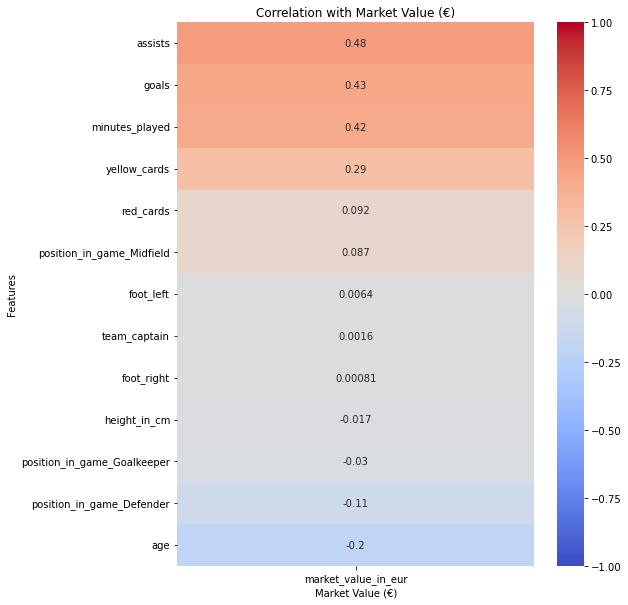

In [57]:
# Select relevant columns from transfer_player_info
columns_to_analyze = ['yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played',
                      'position_in_game', 'foot', 'height_in_cm', 'team_captain', 'age', 
                      'market_value_in_eur']

# Keep only the relevant columns in the dataframe
df = transfer_player_info[columns_to_analyze]

# Numerical features: Calculate correlation directly for numerical columns
numerical_columns = ['yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played', 
                     'height_in_cm', 'team_captain', 'age']

# Encode categorical columns using one-hot encoding
categorical_columns = ['position_in_game', 'foot']
df_encoded = pd.get_dummies(df[categorical_columns], drop_first=True)

# Combine numerical and encoded categorical columns
df_combined = pd.concat([df[numerical_columns], df_encoded, df['market_value_in_eur']], axis=1)

# Calculate the correlation matrix and isolate the column for market_value_in_eur
market_value_corr = df_combined.corr()['market_value_in_eur'].drop('market_value_in_eur')

market_value_corr_sorted = market_value_corr.sort_values(ascending=False)

# correlation heatmap 
plt.figure(figsize=(8, 10))
sns.heatmap(market_value_corr_sorted.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation with Market Value (€)')
plt.xlabel('Market Value (€)')
plt.ylabel('Features')
plt.show()

As expected, the more a player influences the game (by scoring goals or providing assists), the more valuable they become. Conversely, as a player ages increased, their market value tends to decline.

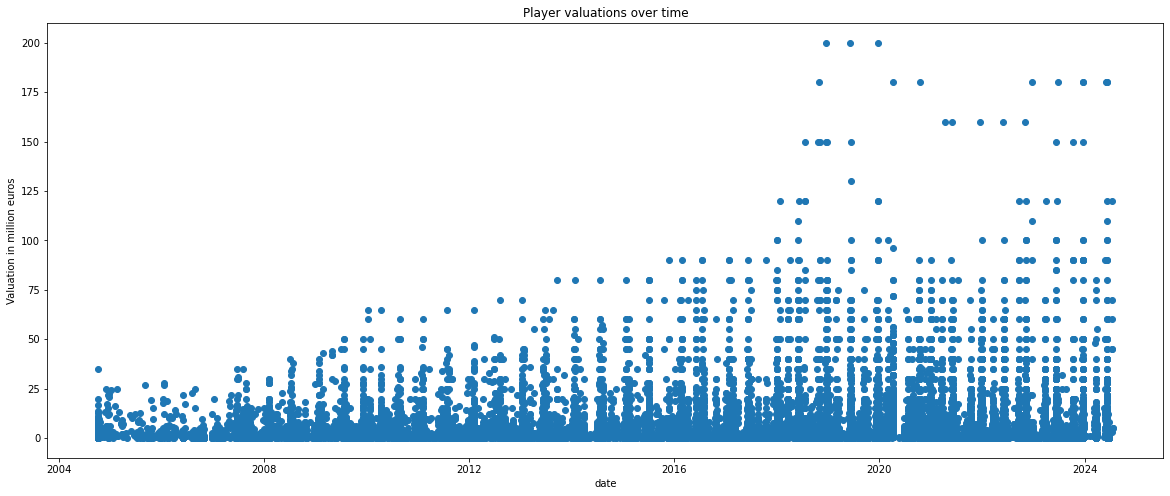

In [58]:
df_valuations = player_valuations[(player_valuations["player_club_domestic_competition_id"]== "ES1")]

df_valuations['date']=pd.to_datetime(df_valuations['date'], format="%Y-%m-%d")

# Visualize of valuation data over time
plt.figure(figsize=(20,8))
plt.scatter(df_valuations['date'],y=df_valuations['market_value_in_eur']/1000000 )
plt.xlabel('date');plt.ylabel('Valuation in million euros')
plt.title('Player valuations over time')
plt.show()

The figure above illustrates the changes in player valuations over time, clearly showing that as time passes, the contract value of players tends to decrease.
(I will visualize similar trend using a bar chart race and email it to you.)